In [2]:
import sys

import matplotlib.pyplot as plt
import json

import numpy as np

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:

# get data
with open("./resources/symb_train_test_data.json", "r") as file:
    all_train_test = json.load(file)

## Make training data

In [ ]:
import sys
import json
import os
import numpy as np


from dysts.base import get_attractor_list
from dysts.analysis import sample_initial_conditions
import dysts.flows

n_train = 150

all_train_test = dict()
for i, equation_name in enumerate(get_attractor_list()):
    
    all_train_test[equation_name] = dict()
    model = getattr(dysts.flows, equation_name)()
    
    np.random.seed(0)
    ic_train, ic_test = sample_initial_conditions(model, 2, traj_length=1000, pts_per_period=30)
    
    model.ic = ic_train
    tvals, sol = model.make_trajectory(n_train, pts_per_period=15, resample=True, return_times=True, standardize=False)
    dt = np.median(np.diff(tvals))
    dsol = np.vstack([model.rhs(val, 0) for val in sol])# * dt
    X_train, y_train = sol, dsol
    t_train = tvals

    model.ic = ic_test
    tvals, sol = model.make_trajectory(n_train, pts_per_period=15, resample=True, return_times=True, standardize=False)
    dt = np.median(np.diff(tvals))
    dsol = np.vstack([model.rhs(val, 0) for val in sol])# * dt
    X_test, y_test = sol, dsol
    t_test = tvals
    
    all_train_test[equation_name]["X_train"] = X_train.tolist()
    all_train_test[equation_name]["X_test"] = X_test.tolist()
    all_train_test[equation_name]["y_train"] = y_train.tolist()
    all_train_test[equation_name]["y_test"] = y_test.tolist()
    all_train_test[equation_name]["t_train"] = t_train.tolist()
    all_train_test[equation_name]["t_test"] = t_test.tolist()
    
    np.any(np.isnan(X_test)) or np.any(np.isnan(X_train))
    
# with open("./resources/symb_train_test_data.json", 'w') as file:
#     json.dump(all_train_test, file, indent=4)

In [4]:
help(model.fit)

Help on method fit in module dsr.task.regression.sklearn:

fit(X, y) method of dsr.task.regression.sklearn.DeepSymbolicRegressor instance



## Symbolic regression

Available benchmarks

+ Eureqa Python API (could not get this to work)
+ PySR
+ pySINDY
+ AI Feynman 2.0
+ Wolfram (only works on univariate problems)

In [13]:
import pysindy as ps

ModuleNotFoundError: No module named 'pysindy'

In [11]:
import json
import pandas as pd
import numpy as np

# import darts
# from darts import TimeSeries
# from darts.metrics import smape
# actual, predicted order
# metric_calc = lambda x0, x1 :  smape(TimeSeries.from_dataframe(pd.DataFrame(x0)), TimeSeries.from_dataframe(pd.DataFrame(x1))) / 200.

from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
metric_calc = lambda x0, x1 : mean_absolute_percentage_error(x0, x1, symmetric=True)

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
# from dysts.analysis import *
from dysts.analysis import sample_initial_conditions


# cwd = os.path.dirname(os.path.realpath(__file__))
cwd = "."
# dataname = os.path.splitext(os.path.basename(os.path.split(input_path)[-1]))[0]
output_path = cwd + "/results/symbolic_scores2.json"

n_train = 150



# get data
with open("./resources/symb_train_test_data.json", "r") as file:
    all_train_test = json.load(file)

try:
    with open(output_path, "r") as file:
        sym_scores = json.load(file)
except FileNotFoundError:
    sym_scores = dict()

for i, equation_name in enumerate(get_attractor_list()):
# for i, equation_name in enumerate(["Lorenz"]):
    print(equation_name)
    
    if equation_name in sym_scores.keys():
        print(f"Entry for {equation_name} found, skipping it.")
        continue
    
#     model = getattr(dysts.flows, equation_name)()
    sym_scores[equation_name] = dict()

    
    X_train = np.array(all_train_test[equation_name]["X_train"])
    y_train = np.array(all_train_test[equation_name]["y_train"])
    X_test = np.array(all_train_test[equation_name]["X_test"])
    y_test = np.array(all_train_test[equation_name]["y_test"])
    t_train = np.array(all_train_test[equation_name]["t_train"])
    t_test = np.array(all_train_test[equation_name]["t_test"])
    
#     np.random.seed(0)
#     ic_train, ic_test = sample_initial_conditions(model, 2, traj_length=1000, pts_per_period=30)

#     model.ic = ic_train
#     tvals, sol = model.make_trajectory(n_train, pts_per_period=15, resample=True, return_times=True, standardize=False)
#     dt = np.median(np.diff(tvals))
#     dsol = np.vstack([model.rhs(val, 0) for val in sol])# * dt
#     X_train, y_train = sol, dsol

#     model.ic = ic_test
#     tvals, sol = model.make_trajectory(n_train, pts_per_period=15, resample=True, return_times=True, standardize=False)
#     dt = np.median(np.diff(tvals))
#     dsol = np.vstack([model.rhs(val, 0) for val in sol])# * dt
#     X_test, y_test = sol, dsol
    
    ndim = min([X_test.shape[-1], y_test.shape[-1]])
    
    
    
#     ## SINDY-poly
#     import pysindy as ps
#     sym_model = ps.SINDy()
#     sym_model.fit(X_train, t=t_train)
#     y_test_pred = sym_model.predict(X_test)
#     all_scores = list()
#     for i in range(ndim):
#         all_scores.append(metric_calc(y_test[:, i], y_test_pred[:, i]))
#     sym_scores[equation_name]["SINDY-poly"] = np.median(all_scores)
    
#     ## SINDY-fourier basis
#     sym_model = ps.SINDy(feature_library=ps.FourierLibrary(n_frequencies=10))
#     sym_model.fit(X_train, t=t_train)
#     y_test_pred = sym_model.predict(X_test)
#     all_scores = list()
#     for i in range(ndim):
#         all_scores.append(metric_calc(y_test[:, i], y_test_pred[:, i]))
#     sym_scores[equation_name]["SINDY-fourier"] = np.median(all_scores)
    
    ## DSR
#     from dsr import DeepSymbolicRegressor
#     # Create the model
#     model = DeepSymbolicRegressor("./private_deep-symbolic-optimization/dsr/dsr/config.json")
#     # Fit the model
#     model.fit(X_train, y_train) # Should solve in ~10 seconds
#     # View the best expression
#     #print(model.program_.pretty())
#     # Make predictions
#     y_test_pred = model.predict(X_test)
#     all_scores = list()
#     for i in range(ndim):
#         all_scores.append(metric_calc(y_test[:, i], y_test_pred[:, i]))
#     sym_scores[equation_name]["DSR"] = np.median(all_scores)

    from dsr import DeepSymbolicRegressor

    # Create the model
    
    # Fit the model
    
    # View the best expression
    #print(model.program_.pretty())
    # Make predictions
    
    all_scores = list()
    for i in range(ndim):
        model = DeepSymbolicRegressor("./private_deep-symbolic-optimization/dsr/dsr/config.json")
        model.fit(X_train, y_train[:, i]) # Should solve in ~10 seconds
        y_test_pred = model.predict(X_test)
        all_scores.append(metric_calc(y_test[:, i], y_test_pred))
    sym_scores[equation_name]["DSR"] = np.median(all_scores)
    
    break
    
#     with open(output_path, 'w') as f:
#         json.dump(sym_scores, f, indent=4)   
    

Aizawa
-- Building prior -------------------
Sequences have minimum length 4.
Sequences have maximum length 30.
[exp] cannot be a child of [log].
[log] cannot be a child of [exp].
[sin, cos] cannot be a descendant of [sin, cos].
-------------------------------------

New best overall
	Reward: 0.5873411531115763
	Base reward: 0.5873411531115763
	Count: 1
	Invalid: False
	Traversal: sub,add,x3,cos,x3,exp,x2
	Expression:
	        x₂          
	  x₃ - ℯ   + cos(x₃)


New best overall
	Reward: 0.5951053915114818
	Base reward: 0.5951053915114818
	Count: 1
	Invalid: False
	Traversal: mul,x2,sub,x1,exp,x2
	Expression:
	     ⎛      x₂⎞
	  x₂⋅⎝x₁ - ℯ  ⎠


New best overall
	Reward: 0.6615356308162319
	Base reward: 0.6615356308162319
	Count: 1
	Invalid: False
	Traversal: add,mul,x2,x1,sub,sub,x2,add,x2,x2,add,sin,div,mul,div,x3,exp,sub,mul,x1,exp,exp,x1,div,exp,x2,x3,x3,x2,x2
	Expression:
	                    ⎛           ⎛ x₁⎞    x₂⎞
	                    ⎜           ⎝ℯ  ⎠   ℯ  ⎟
	                 

In [12]:

np.median(all_scores)

0.3375045335704908

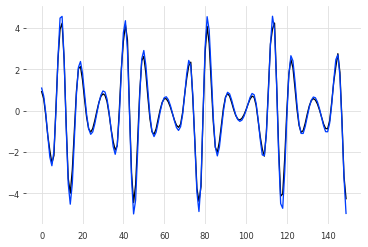

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(y_test_pred)
plt.plot(y_test[:, i])

In [18]:
X_train.shape

(150, 3)

In [19]:
y_train.shape

(150, 3)

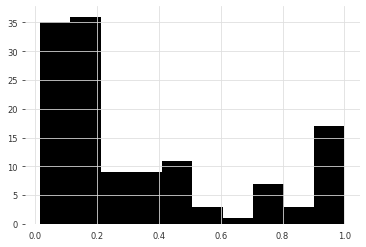

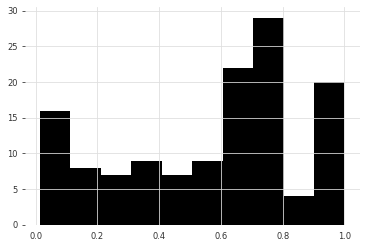

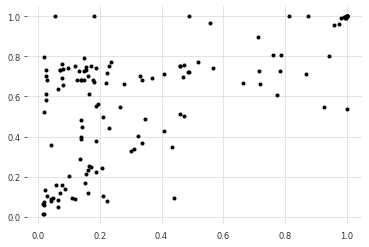

In [60]:
score_vals = np.array([(sym_scores[item]["SINDY-poly"], sym_scores[item]["SINDY-fourier"]) for item in sym_scores])

plt.figure()
plt.hist(score_vals[:, 0])

plt.figure()
plt.hist(score_vals[:, 1])

plt.figure()
plt.plot(*score_vals.T, '.');

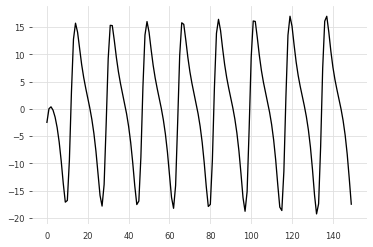

In [75]:
plt.plot(y_train[:, 1])

In [65]:
# import darts
# from darts import TimeSeries
# from darts.metrics import smape

# import pandas as pd

from pysr import pysr, best
y_test_pred = list()
for i in range(ndim):
    print(i)
    # Learn equations
    equations = pysr(
        X_train,
        y_train[:, i],
        populations=3, # number of workers, defaults to 20
        niterations=5,
        procs=1, # number of threads
        binary_operators=["+", "*"],
        unary_operators=[
            "cos",
            "exp",
            "sin",
            "tanh",
            "inv(x) = 1/x",
        ],
        verbosity=0,
    )
    # print(best(equations))
    best_ind = np.argmax(equations["score"].values) 
    y_test_pred.append(equations["lambda_format"].iloc[best_ind](X_test))
y_test_pred = np.array(y_test_pred)

print(metric_calc(y_test, y_test_pred))

0
1
Killing process... will return when done.


RuntimeError: Couldn't find equation file! The equation search likely exited before a single iteration completed.

Init signature: ps.FourierLibrary(n_frequencies=1, include_sin=True, include_cos=True)
Docstring:     
Generate a library with trigonometric functions.

Parameters
----------
n_frequencies : int, optional (default 1)
    Number of frequencies to include in the library. The library will
    include functions :math:`\sin(x), \sin(2x), \dots \sin(n_{frequencies}x)`
    for each input feature :math:`x` (depending on which of sine and/or cosine
    features are included).

include_sin : boolean, optional (default True)
    If True, include sine terms in the library.

include_cos : boolean, optional (default True)
    If True, include cosine terms in the library.

Attributes
----------
n_input_features_ : int
    The total number of input features.

n_output_features_ : int
    The total number of output features. The number of output features
    is ``2 * n_input_features_ * n_frequencies`` if both sines and cosines
    are included. Otherwise it is ``n_input_features * n_frequencies``.

Ex

In [39]:
?ps.SINDy

Init signature:
ps.SINDy(
    optimizer=None,
    feature_library=None,
    differentiation_method=None,
    feature_names=None,
    t_default=1,
    discrete_time=False,
)
Docstring:     
Sparse Identification of Nonlinear Dynamical Systems (SINDy).
Uses sparse regression to learn a dynamical systems model from measurement data.

Parameters
----------
optimizer : optimizer object, optional
    Optimization method used to fit the SINDy model. This must be a class
    extending :class:`pysindy.optimizers.BaseOptimizer`.
    The default is :class:`STLSQ`.

feature_library : feature library object, optional
    Feature library object used to specify candidate right-hand side features.
    This must be a class extending
    :class:`pysindy.feature_library.base.BaseFeatureLibrary`.
    The default option is :class:`PolynomialLibrary`.

differentiation_method : differentiation object, optional
    Method for differentiating the data. This must be a class extending
    :class:`pysindy.differe

In [27]:
y_test[:, i], y_test_pred[:, i]

In [29]:
y_test_pred2.shape

(150, 3)

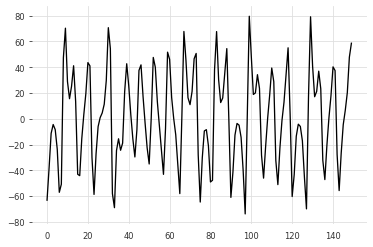

In [26]:
plt.plot(y_test_pred2[:, 0])

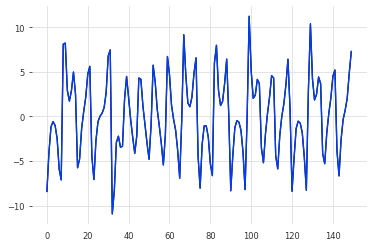

In [16]:
plt.plot(y_test_pred)
plt.plot(y_test)

## nODEs